# PLS Regression to Predict Age

Note: The resources used while building this model are as follows:
1. https://nirpyresearch.com/partial-least-squares-regression-python/

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.cross_decomposition import PLSRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import seaborn as sb

# Data

In [3]:
data = pd.read_csv("./Volumetric_features.csv")

data_features = pd.DataFrame(data, columns = data.columns[:-1])
data_features = data_features.drop(['S.No','Age'], axis=1)

data_features.head()
data_features.describe()

,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,4th-Ventricle,...,rh_superiorparietal_thickness,rh_superiortemporal_thickness,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent.2,eTIV.1
count,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,...,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03
mean,13370.040795,574.849716,14646.696711,52002.811571,7164.947539,3337.653526,4505.158755,1958.214458,1418.947373,1797.243469,...,2.117151,2.655624,2.429779,2.684327,3.555803,2.288283,2.846123,2.372266,1.085468e+06,1.514925e+06
std,9194.928348,594.590387,2622.868798,6378.435917,1207.229615,502.352001,713.658580,287.139826,635.143286,583.220321,...,0.174228,0.207942,0.185543,0.275245,0.332094,0.269851,0.195038,0.146944,1.248881e+05,1.651798e+05
min,2204.100000,0.000000,6920.100000,29911.800000,4145.400000,1035.600000,2294.000000,851.900000,39.700000,371.900000,...,1.499000,1.563000,1.345000,1.655000,1.940000,1.176000,1.533000,1.483290,6.279600e+05,8.329815e+05
25%,7031.625000,243.200000,12909.875000,47359.675000,6239.425000,2984.500000,4008.125000,1764.700000,941.825000,1408.050000,...,2.002250,2.521000,2.309000,2.510000,3.360000,2.105000,2.720000,2.274935,9.957585e+05,1.404471e+06
50%,10669.950000,385.800000,14277.000000,51333.650000,7032.150000,3294.050000,4438.100000,1940.100000,1225.450000,1683.850000,...,2.130000,2.665000,2.440500,2.685000,3.586500,2.297000,2.851000,2.383375,1.075919e+06,1.511767e+06
75%,17332.650000,720.825000,15959.725000,56287.775000,7977.400000,3655.125000,4963.025000,2128.000000,1780.225000,2044.525000,...,2.245000,2.808000,2.562750,2.851000,3.790000,2.476000,2.975000,2.483143,1.168888e+06,1.625445e+06
max,79812.500000,7533.800000,35042.500000,79948.200000,13008.300000,6018.000000,8446.100000,4357.700000,4461.600000,5312.400000,...,2.671000,3.240000,2.996000,3.928000,4.487000,3.123000,3.482000,2.803730,1.545129e+06,2.075213e+06


# Preprocessing

## Pulling top features

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x = scaler.fit_transform(data_features)
n = 20
pca = PCA(n_components=n)
pca_dataF = pca.fit_transform(x)

labels = data_features.columns.values.tolist()
label_index = [np.abs(pca.components_[i]).argmax() for i in range(n)]
columns = [labels[label_index[i]] for i in range(n)]

pca_df = pd.DataFrame(data=pca_dataF, columns=columns)
pca_df.head()
pca_df.describe()

,rh_MeanThickness_thickness,CerebralWhiteMatterVol,Left-Lateral-Ventricle,lh_pericalcarine_thickness,SurfaceHoles,CC_Posterior,rh_caudalanteriorcingulate_thickness,CC_Posterior,Right-Caudate,lh_parahippocampal_thickness,MaskVol-to-eTIV,Brain-Stem,Left-vessel,Right-vessel,non-WM-hypointensities,rh_isthmuscingulate_thickness,5th-Ventricle,5th-Ventricle,5th-Ventricle,5th-Ventricle
count,4.226000e+03,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4.226000e+03,4226.000000
mean,-2.152141e-16,0.000000,0.000000,5.380352e-17,-5.380352e-17,2.690176e-17,2.690176e-17,-1.345088e-17,-2.690176e-17,-4.539672e-17,-2.690176e-17,-2.017632e-17,-6.052896e-17,3.026448e-17,1.849496e-17,7.397984e-17,-3.362720e-17,-3.867128e-17,4.035264e-17,0.000000
std,7.049398e+00,4.329355,2.571239,2.053967e+00,1.898625e+00,1.576450e+00,1.500158e+00,1.393173e+00,1.335883e+00,1.294370e+00,1.226696e+00,1.204529e+00,1.168633e+00,1.124252e+00,1.059447e+00,1.048038e+00,1.024572e+00,1.006987e+00,9.897956e-01,0.979169
min,-2.098823e+01,-14.763074,-9.547908,-5.983893e+00,-5.243716e+00,-8.401343e+00,-6.703934e+00,-5.457148e+00,-7.148809e+00,-1.045361e+01,-7.636755e+00,-5.280996e+00,-4.123450e+00,-3.931352e+00,-5.925746e+00,-4.133626e+00,-6.793404e+00,-1.246673e+01,-2.934572e+00,-4.701749
25%,-5.383383e+00,-2.976356,-1.736099,-1.333377e+00,-1.262188e+00,-1.005933e+00,-9.843742e-01,-9.128912e-01,-8.407157e-01,-7.304263e-01,-7.270235e-01,-8.083532e-01,-7.557505e-01,-6.788104e-01,-5.060874e-01,-6.477301e-01,-6.420107e-01,-4.827728e-01,-5.539264e-01,-0.564434
50%,-3.654960e-01,-0.253423,-0.134482,-1.939464e-01,-2.721898e-01,1.799869e-02,-4.118156e-02,-4.797268e-02,-8.900816e-02,3.965174e-02,-1.044510e-01,-3.524901e-02,-1.073991e-02,-1.057154e-01,3.095962e-02,-1.354980e-03,-2.817101e-02,2.794047e-02,-1.989168e-02,-0.034436
75%,5.158247e+00,2.876861,1.637424,1.146679e+00,9.012933e-01,1.029292e+00,9.454824e-01,8.393697e-01,7.560498e-01,7.845750e-01,6.288807e-01,7.881735e-01,6.997766e-01,5.662654e-01,5.599834e-01,6.673823e-01,6.128146e-01,5.289918e-01,4.940248e-01,0.464756
max,3.848363e+01,24.636829,13.503781,2.781149e+01,1.887185e+01,8.591761e+00,9.957076e+00,7.668056e+00,1.718137e+01,1.237015e+01,1.647663e+01,9.509926e+00,6.597732e+00,1.090843e+01,2.766904e+01,7.892053e+00,7.447956e+00,1.780808e+01,1.959368e+01,10.423043


## Heatmap

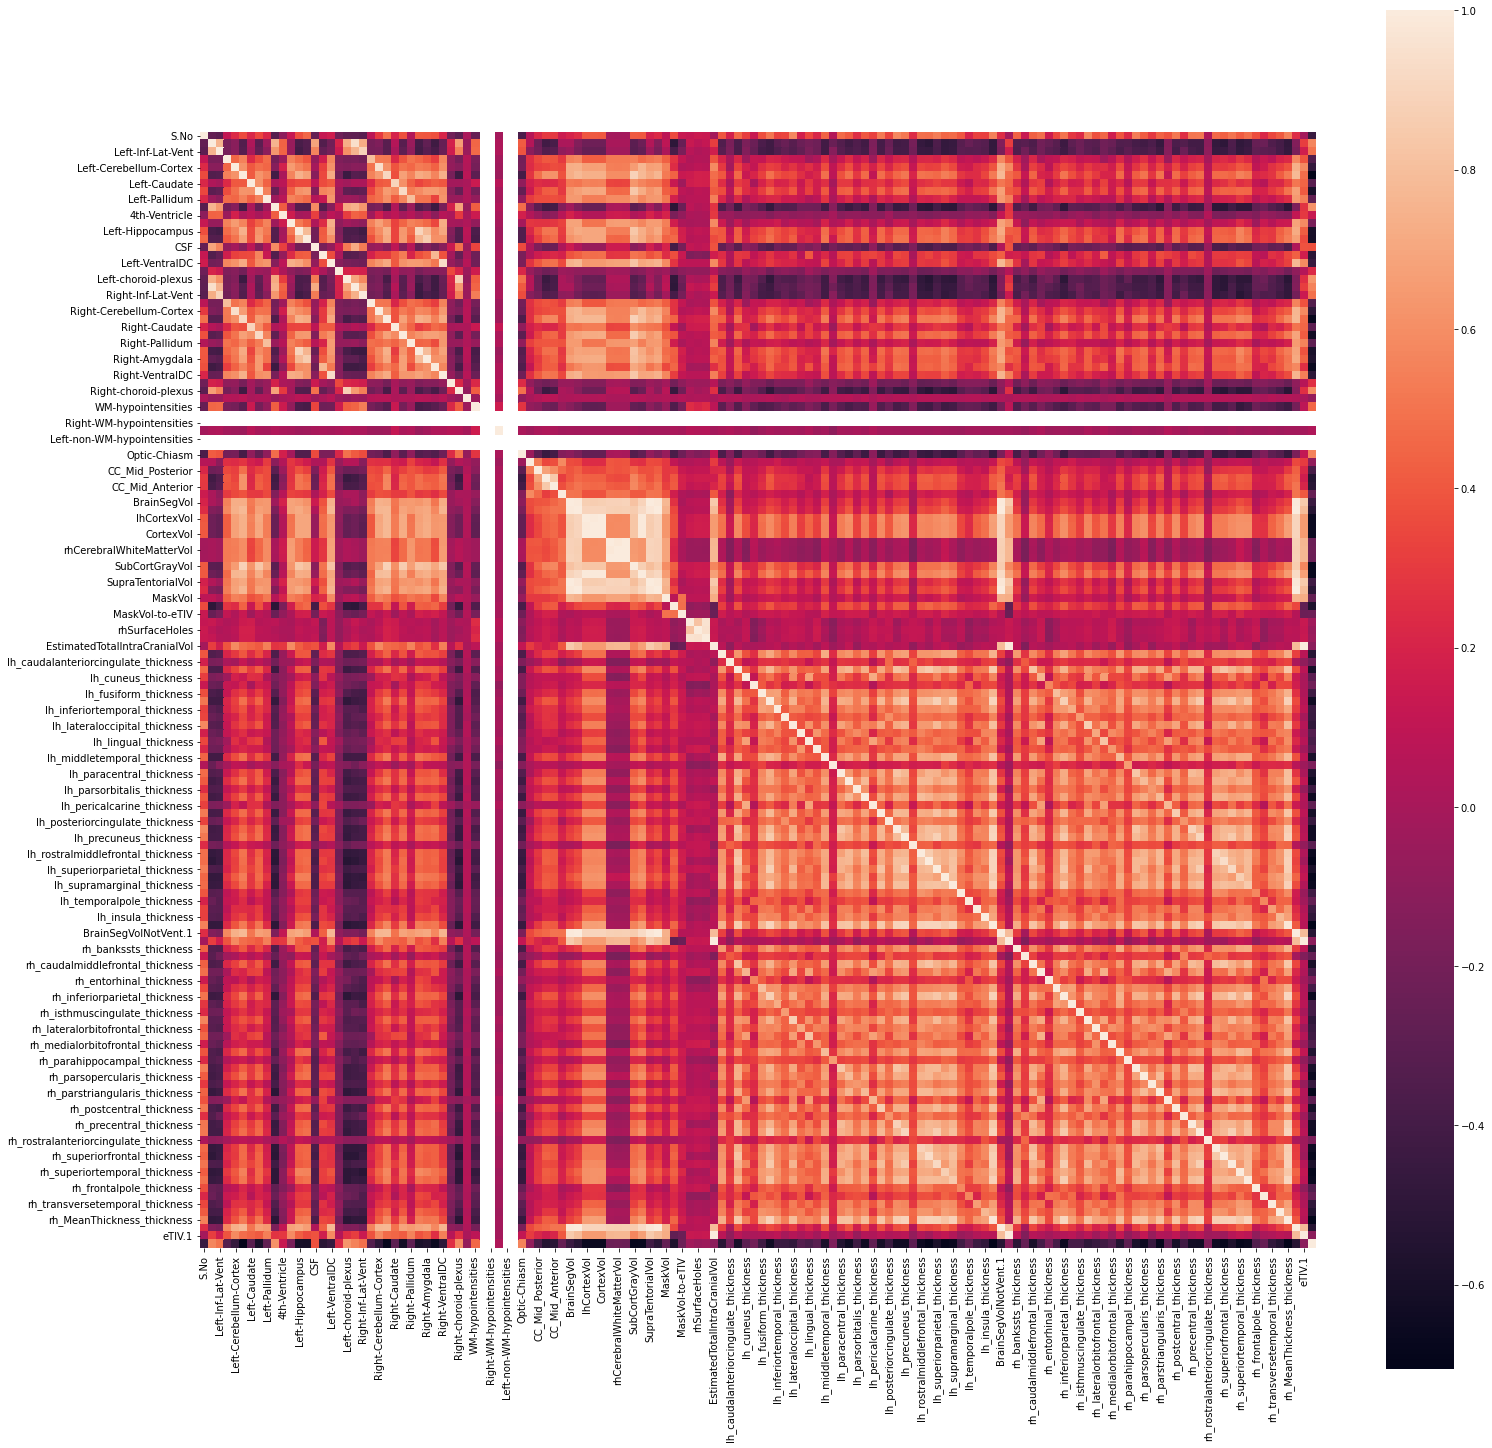

In [5]:
C_mat = data.iloc[:,:-1].corr()
fig = plt.figure(figsize = (25,25))

sb.heatmap(C_mat, square=True)
plt.show()

# Training

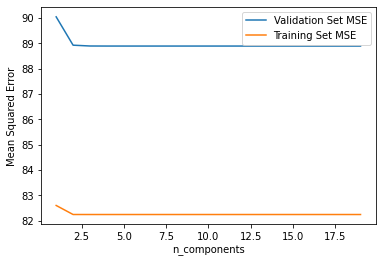

Min MSE: 88.8914862759964at n_components=5


In [6]:
# Split out train data, 80%, and the rest, 20%
X_train, X_rest, Y_train, Y_rest = train_test_split(pca_df, data['Age'], test_size=0.20, random_state=33)
# Spit out validate data, 15% (of total, 75% of X_rest), and test, 5% (of total, 25% of rest)
X_validate, X_test, Y_validate, Y_test = train_test_split(X_rest, Y_rest, test_size=0.25, random_state=33)

n_components = range(1,20)
train_accuracy = np.empty(len(n_components))
validation_accuracy = np.empty(len(n_components))

for i, components in enumerate(n_components):
    model = PLSRegression(n_components = components)
    model.fit(X_train, Y_train)
    
    Y_pred_train = model.predict(X_train)
    Y_pred_validate = model.predict(X_validate)
    
    train_accuracy[i] = metrics.mean_squared_error(Y_train, Y_pred_train)
    validation_accuracy[i] = metrics.mean_squared_error(Y_validate, Y_pred_validate)

plt.plot(n_components, validation_accuracy, label='Validation Set MSE')
plt.plot(n_components, train_accuracy, label='Training Set MSE')

plt.legend()
plt.xlabel('n_components')
plt.ylabel('Mean Squared Error')
plt.show()

mse_res = np.array(validation_accuracy)

print("Min MSE: " + str(min(mse_res)) + "at n_components=" + str(list(mse_res).index(min(mse_res)) + 1))

# Testing

In [8]:
pls = PLSRegression(n_components=20)
pls.fit(X_train, Y_train)
Y_pred = pls.predict(X_test)

print("Explained variance: " + str(metrics.explained_variance_score(Y_test, Y_pred)))
print("Max Error: " + str(metrics.max_error(Y_test, Y_pred)))
print("Mean absolute error: " + str(metrics.mean_absolute_error(Y_test, Y_pred)))
print("Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred)))
print("Root Mean squared error: " + str(metrics.mean_squared_error(Y_test, Y_pred, squared=False)))
print("R2: " + str(metrics.r2_score(Y_test, Y_pred)))



Explained variance: 0.786206619002398
Max Error: 21.239848348414142
Mean absolute error: 7.646024701974211
Mean squared error: 83.82750515662478
Root Mean squared error: 9.155736188675643
R2: 0.7862027184736574
